In [23]:
from util import get_image_by_index, decode_class

import numpy as np
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## Loading Image datasetset

In [ ]:
# Load the .npz file
data = np.load('dataset_features.npz')

# List all arrays within the .npz file
print(data.files)

# Access individual arrays by their names
X_train = data['trainset_features']
y_train = data['trainset_labels']

X_val = data['validset_features']
y_val = data['validset_labels']

X_test = data['testset_features']
y_test = data['testset_labels']

class_labels = data['class_labels']


['trainset_features', 'validset_features', 'testset_features', 'trainset_labels', 'validset_labels', 'testset_labels', 'class_labels']


In [ ]:
# Create a k-NN pipeline
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), 
     ("knn", KNeighborsClassifier(n_neighbors=6))]
)

In [ ]:
# [Code adapted from the previous course]
# Variable to store the results
gs_results = []

# Generate a set of k values
k_values = np.arange(1, 50, step=1)

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_train, y_train)

    # Save model and its performance on training/validation sets
    gs_results.append(
        {
            "k": k,
            "train_accuracy": knn_pipe.score(X_train, y_train),
            "valid_accuracy": knn_pipe.score(X_val, y_val),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by="valid_accuracy", ascending=False).head()

,k,train_accuracy,valid_accuracy
0,1,1.000000,0.863309
6,7,0.882143,0.856115
14,15,0.850000,0.848921
8,9,0.860714,0.848921
7,8,0.850000,0.848921


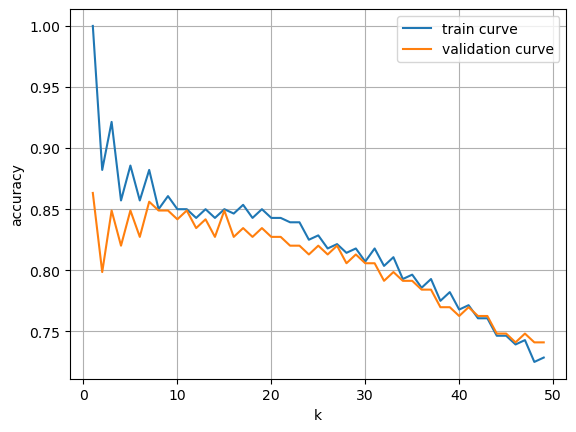

In [ ]:
# Plot the validation curves
plt.plot(gs_results["k"], gs_results["train_accuracy"], label="train curve")
plt.plot(gs_results["k"], gs_results["valid_accuracy"], label="validation curve")
plt.ylabel("accuracy")
plt.xlabel("k")
plt.grid(True)
plt.legend()
plt.show()

Low values of k, present high training accuracy, but in this region we're overfitting as can be seen by the accuracy gap between training and validation sets.

For higher k, both training and validation sets accuracy decreases since we're now underfitting and increasing the model variance. 

Tuned classifier that maximizes the accuracy in validation set has k=7

In [5]:
# Create a k-NN pipeline
knn_pipe_tuned = Pipeline(
    [("scaler", StandardScaler()), 
     ("knn", KNeighborsClassifier(n_neighbors=5))]
)

knn_pipe_tuned.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

## Classification Report

In [ ]:
# Classification report
y_test_preds = knn_pipe_tuned.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        bike       1.00      1.00      1.00        12
         car       0.92      1.00      0.96        11
  motorcycle       1.00      1.00      1.00         9
       other       1.00      0.67      0.80         6
       truck       1.00      0.86      0.92         7
         van       1.00      0.80      0.89         5

   micro avg       0.98      0.92      0.95        50
   macro avg       0.99      0.89      0.93        50
weighted avg       0.98      0.92      0.94        50
 samples avg       0.92      0.92      0.92        50



/home/miguel/miniconda3/envs/adsml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: Measures the accuracy of positive predictions for each class. It is the proportion of true positives out of all instances classified as that class. 

Recall: Measures the ability of the classifier to identify all true positives for each class. It is the proportion of true positives out of all actual instances of that class. 

Support: The number of actual instances in each class. Categories like bike (33), car (32), and motorcycle (25) have a higher number of samples, which typically leads to more reliable metrics.

## Confusion Matrix

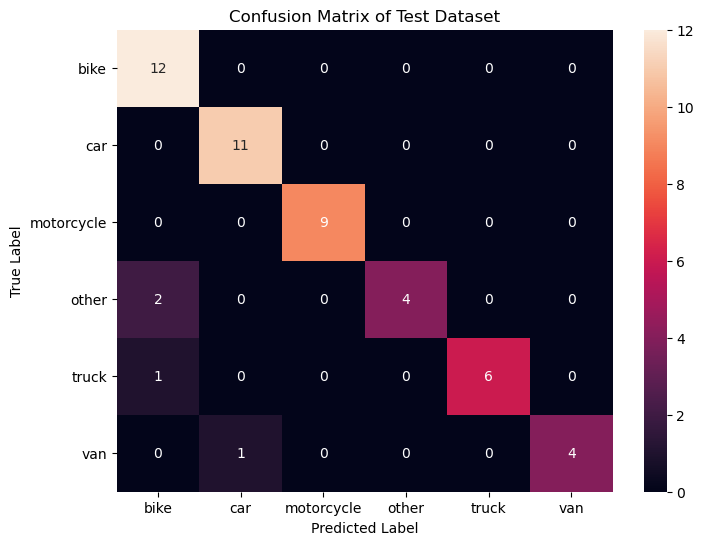

In [ ]:
# Define class labels
class_labels = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

y_test_decoded = np.argmax(y_test, axis=1)
y_pred_decoded = np.argmax(y_test_preds, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Test Dataset")
plt.show()

## Correct classifications and nearest neighbours

In [8]:
import numpy as np

# Find the correctly classified test images
correct_indices = np.where(y_test_decoded == y_pred_decoded)[0]
print(f'Number of correctly classified images: {len(correct_indices)}')

Number of correctly classified images: 46


In [ ]:
# Define image size and scaling
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)  # Adjust rescaling if needed
test_images = datagen.flow_from_directory('./test', target_size=image_size, batch_size=batch_size, shuffle=False)
train_images = datagen.flow_from_directory('./train', target_size=image_size, batch_size=batch_size, shuffle=False)

2024-11-23 15:49:01.382521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-23 15:49:01.382562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 50 images belonging to 6 classes.
Found 280 images belonging to 6 classes.


Select an image index

Selection of correctly classified image
Index: 0
Label: bike


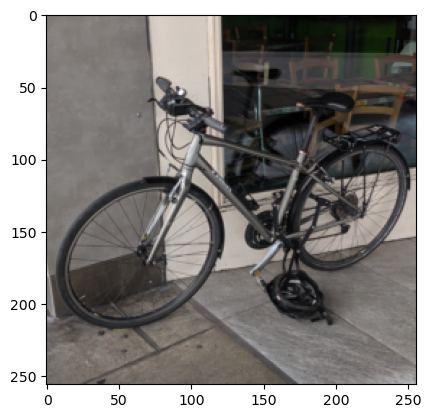

In [12]:
idx = 0
chosen_index = correct_indices[idx]

image, label = get_image_by_index(test_images, chosen_index)
plt.imshow(image)
print(f'Selection of correctly classified image')
print(f'Index: {chosen_index}')
print(f'Label: {class_labels[label]}')

Let's now find the nearest image entries to selected test imageset

In [13]:
scaler = knn_pipe_tuned.named_steps['scaler']
knn = knn_pipe_tuned.named_steps['knn']

knn_scale = Pipeline(
    [("scaler", scaler), 
     ]
)

X_test_transf = knn_scale.transform(X_test)

In [14]:
from sklearn.neighbors import NearestNeighbors

nearest_distances, nearest_indices = knn.kneighbors(X_test_transf[chosen_index,:].reshape(1, -1), n_neighbors=10)

nearest_distances = nearest_distances[0]
nearest_indices = nearest_indices[0]

print(f'Nearest distances: {nearest_distances}')
print(f'Nearest indices  : {nearest_indices}')

Nearest distances: [24.762861 25.114796 26.214863 28.247377 28.310545 28.977236 29.228243
 29.355764 30.41604  30.483484]
Nearest indices  : [26 10 61 17 30 22 21 59 14 16]


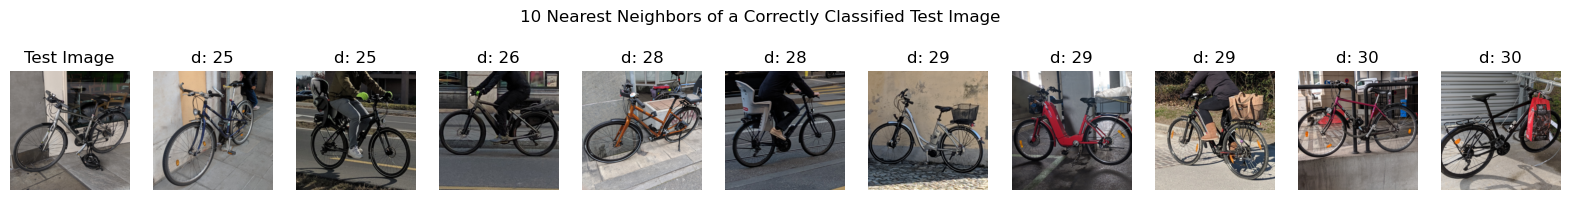

In [15]:
# Plot the chosen test image
fig, axes = plt.subplots(1, 11, figsize=(20, 2.5))

chosen_image, chosen_label = get_image_by_index(test_images, chosen_index)
axes[0].imshow(chosen_image)
axes[0].set_title("Test Image")
axes[0].axis("off")

# Plot the 10 nearest neighbors from the training set
for i, nearest_index in enumerate(nearest_indices, start=1):
       
    nearest_image, nearest_label = get_image_by_index(train_images, nearest_index)
    axes[i].imshow(nearest_image)
    axes[i].set_title(f"d: {nearest_distances[i-1]:.0f}")  
    axes[i].axis("off")

plt.suptitle("10 Nearest Neighbors of a Correctly Classified Test Image")
plt.show()


## Incorrect classifications and nearest neighbours

In [16]:
# Find the incorrectly classified test images
incorrect_indices = np.where(y_test_decoded != y_pred_decoded)[0]
print(f'Number of incorrectly classified images: {len(incorrect_indices)}')

Number of incorrectly classified images: 4


Select an image index

Selection of correctly classified image
Index: 33
Label: other


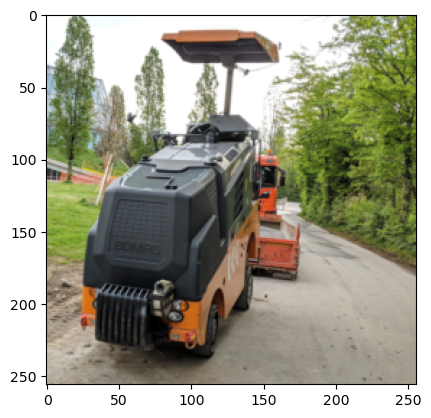

In [17]:
idx = 0
chosen_index = incorrect_indices[idx]

image, label = get_image_by_index(test_images, chosen_index)
plt.imshow(image)
print(f'Selection of correctly classified image')
print(f'Index: {chosen_index}')
print(f'Label: {class_labels[label]}')

Let's now find the nearest image entries to selected test imageset

In [18]:
from sklearn.neighbors import NearestNeighbors

nearest_distances, nearest_indices = knn.kneighbors(X_test_transf[chosen_index,:].reshape(1, -1), n_neighbors=10)

nearest_distances = nearest_distances[0]
nearest_indices = nearest_indices[0]

print(f'Nearest distances: {nearest_distances}')
print(f'Nearest indices  : {nearest_indices}')

Nearest distances: [51.196247 52.41696  52.497513 52.59886  52.74782  52.792633 52.8526
 52.900642 53.18906  53.487423]
Nearest indices  : [184 194 228 159  97 219 211 199 182 155]


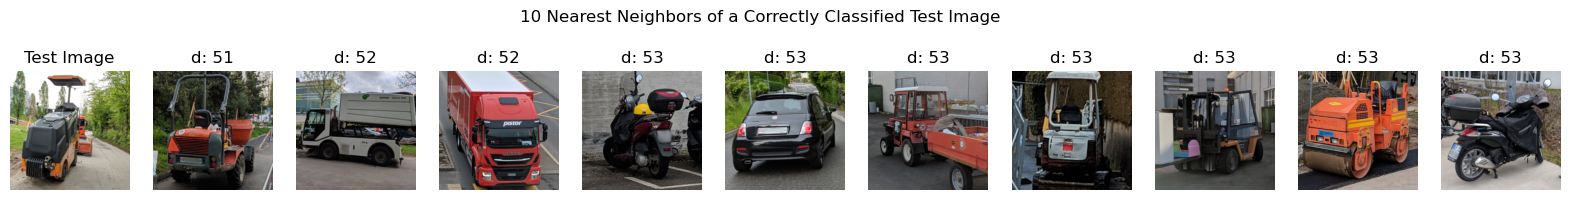

In [19]:
# Plot the chosen test image
fig, axes = plt.subplots(1, 11, figsize=(20, 2.5))

chosen_image, chosen_label = get_image_by_index(test_images, chosen_index)
axes[0].imshow(chosen_image)
axes[0].set_title("Test Image")
axes[0].axis("off")

# Plot the 10 nearest neighbors from the training set
for i, nearest_index in enumerate(nearest_indices, start=1):
       
    nearest_image, nearest_label = get_image_by_index(train_images, nearest_index)
    axes[i].imshow(nearest_image)
    axes[i].set_title(f"d: {nearest_distances[i-1]:.0f}")  
    axes[i].axis("off")

plt.suptitle("10 Nearest Neighbors of a Correctly Classified Test Image")
plt.show()
